# Advanced Recommender Systems with Python
Chào mừng bạn đến với sổ tay mã cho việc tạo Hệ thống Đề xuất Nâng cao bằng Python. Đây là một sổ tay bài giảng tùy chọn mà bạn có thể kiểm tra. Hiện tại, không có video cho bài giảng này do mức độ toán học sử dụng và việc sử dụng nhiều thư viện SciPy khá phức tạp.

Hệ thống Đề xuất thường phụ thuộc vào các tập dữ liệu lớn và cần được tổ chức theo một cách cụ thể. Do đó, chúng tôi sẽ không có một dự án đi kèm với chủ đề này. Thay vào đó, chúng tôi sẽ có một quá trình hướng dẫn chi tiết hơn về việc tạo hệ thống đề xuất bằng Python với Bộ dữ liệu Movie Lens cùng.

Lưu ý: Toán học thực tế đằng sau hệ thống đề xuất khá phức tạp trong Đại số Tuyến tính.








# Methods Used
Hai loại hệ thống đề xuất phổ biến nhất là Hệ thống dựa trên Nội dung (Content-Based) và Lọc cộng tác (Collaborative Filtering - CF).

Lọc cộng tác tạo ra các đề xuất dựa trên sự hiểu biết về thái độ của người dùng đối với các mục, tức là nó sử dụng "trí tuệ của đám đông" để đề xuất các mục.
Hệ thống đề xuất dựa trên nội dung tập trung vào các thuộc tính của các mục và đưa ra các đề xuất dựa trên sự tương đồng giữa chúng.

# Collabrative Filtering
Nói chung, Lọc cộng tác (Collaborative Filtering - CF) thường được sử dụng phổ biến hơn so với các hệ thống dựa trên nội dung vì thường mang lại kết quả tốt hơn và tương đối dễ hiểu (từ góc độ triển khai tổng thể). Thuật toán có khả năng tự thực hiện việc học từ các đặc trưng của chính nó, có nghĩa là nó có thể bắt đầu tự học những đặc trưng nào nên sử dụng.

CF có thể chia thành hai phần là Lọc cộng tác dựa trên Bộ nhớ (Memory-Based Collaborative Filtering) và Lọc cộng tác dựa trên Mô hình (Model-Based Collaborative Filtering).

Trong hướng dẫn này, chúng ta sẽ thực hiện Lọc cộng tác dựa trên Mô hình bằng cách sử dụng phân tích giá trị riêng (Singular Value Decomposition - SVD) và Lọc cộng tác dựa trên Bộ nhớ bằng cách tính toán độ tương đồng cosine.


# The Data
Chúng ta sẽ sử dụng bộ dữ liệu nổi tiếng MovieLens, đây là một trong những bộ dữ liệu phổ biến nhất được sử dụng khi triển khai và kiểm thử các hệ thống đề xuất. Bộ dữ liệu này chứa 100 nghìn đánh giá phim từ 943 người dùng và một lựa chọn 1682 bộ phim.

Bạn có thể tải xuống bộ dữ liệu tại đây hoặc chỉ cần sử dụng tệp u.data đã được bao gồm trong thư mục này.


# Getting started
Hãy nhập một số thư viện chúng ta sẽ cần:









In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Sau đó chúng ta  có thể đọc tệp u.data, chứa toàn bộ bộ dữ liệu. Bạn có thể đọc mô tả ngắn về bộ dữ liệu ở đây.http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

Hãy xem qua tập dữ liệu này nhé !

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Lưu ý rằng chúng ta chỉ có item_id, không có tên phim. Chúng ta có thể sử dụng tệp csv Movie_ID_Titles để lấy tên phim và hợp nhất nó với dataframe này.






In [4]:
movie_titles = pd.read_csv('Movie_Id_Titles')
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Sau đó hợp nhất các dataframe lại. 

In [5]:
df = pd.merge(df,movie_titles, on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


Bây giờ, hãy xem nhanh số lượng người dùng và phim duy nhất

In [6]:
n_users = df.user_id.nunique()
n_movie = df.item_id.nunique()

print("Num of User: " + str(n_users))
print("Num of Movie: " + str(n_movie))

Num of User: 944
Num of Movie: 1682


# EDA
Visualization Data

Hãy tạo khung dữ liệu xếp hạng với xếp hạng trung bình và số lượng xếp hạng

In [7]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
They Made Me a Criminal (1939)                5.0
Marlene Dietrich: Shadow and Light (1996)     5.0
Saint of Fort Washington, The (1993)          5.0
Someone Else's America (1995)                 5.0
Star Kid (1997)                               5.0
Name: rating, dtype: float64

In [8]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [9]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Bây giờ hãy đặt cột số lượng xếp hạng:

In [10]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Bây giờ hãy vẽ một số histograms:

<Axes: xlabel='num of ratings', ylabel='Count'>

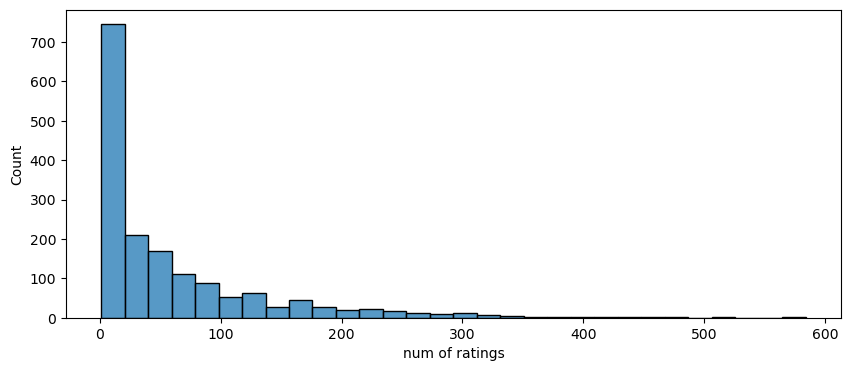

In [11]:
plt.figure(figsize=(10,4))
sns.histplot(ratings['num of ratings'], bins=30)

<Axes: xlabel='rating', ylabel='Count'>

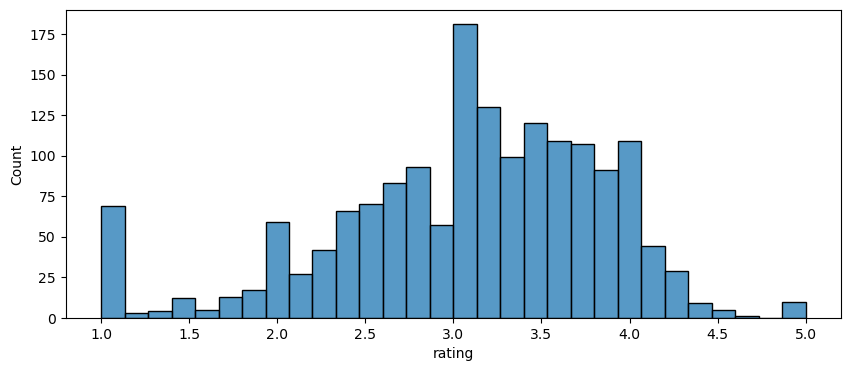

In [12]:
plt.figure(figsize=(10,4))
sns.histplot(ratings['rating'], bins=30)

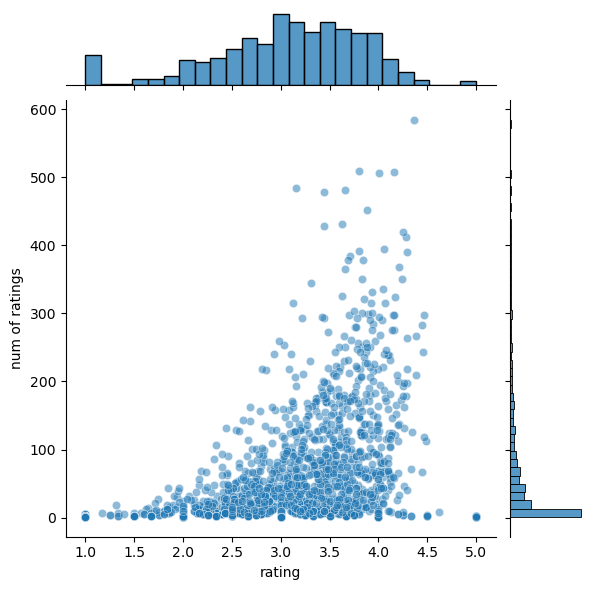

In [13]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

# Train Test Split
Hệ thống Đề xuất theo bản chất của chúng rất khó để đánh giá, nhưng chúng tôi vẫn sẽ hướng dẫn bạn cách đánh giá chúng trong bài hướng dẫn này. Để làm điều này, chúng tôi sẽ chia dữ liệu của chúng ta thành hai tập. Tuy nhiên, chúng tôi sẽ không thực hiện việc chia truyền thống thành X_train, X_test, y_train, y_test. Thay vào đó, chúng tôi có thể tách dữ liệu thành hai tập dữ liệu riêng biệt:

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_data, test_data = train_test_split(df, test_size=0.25)

# Memory-Based Collaborative Filtering
Các phương pháp Lọc cộng tác dựa trên Bộ nhớ có thể chia thành hai phần chính: lọc người dùng-sản phẩm và lọc sản phẩm-sản phẩm.

Lọc người dùng-sản phẩm sẽ lấy một người dùng cụ thể, tìm những người dùng tương tự dựa trên sự tương đồng của các đánh giá, và đề xuất các sản phẩm mà những người dùng tương tự đó đã thích.

Trái lại, lọc sản phẩm-sản phẩm sẽ lấy một sản phẩm, tìm những người dùng đã thích sản phẩm đó, và tìm các sản phẩm khác mà những người dùng đó hoặc những người dùng tương tự cũng đã thích. Nó lấy các sản phẩm và đưa ra các sản phẩm khác như gợi ý.

Lọc cộng tác sản phẩm-sản phẩm: "Những người dùng thích sản phẩm này cũng thích..."

Lọc cộng tác người dùng-sản phẩm: "Những người dùng tương tự bạn cũng thích..."







Trong cả hai trường hợp, bạn tạo ra một ma trận người dùng-sản phẩm được xây dựng từ toàn bộ tập dữ liệu.

Vì chúng tôi đã chia dữ liệu thành tập kiểm tra và tập huấn luyện, chúng ta sẽ cần tạo ra hai ma trận [943 x 1682] (tất cả người dùng theo tất cả phim).

Ma trận huấn luyện chứa 75% số lượng đánh giá và ma trận kiểm tra chứa 25% số lượng đánh giá.

Ví dụ về ma trận User-Item:
![Text description](BLOG_CCA_8.png)


Sau khi bạn đã xây dựng ma trận User-Item, bạn sẽ tính toán sự tương đồng và tạo ra một ma trận tương đồng.

Các giá trị tương đồng giữa các mục trong *Item-Item Collaborative Filtering* được đo bằng cách quan sát tất cả những người dùng đã đánh giá cả hai mục.

![Text description](BLOG_CCA_10.png)





Đối với *Lọc cộng tác Người dùng-Sản phẩm*, các giá trị tương đồng giữa người dùng được đo bằng cách quan sát tất cả các mục mà cả hai người dùng đã đánh giá.
![Text description](BLOG_CCA_11.png)

Một phép đo khoảng cách thường được sử dụng trong các hệ thống đề xuất là **cosine similarity**, trong đó các đánh giá được coi như các vector trong không gian n chiều và sự tương đồng được tính toán dựa trên góc giữa các vector này. à **cosine similarity** cho người dùng a và m có thể được tính bằng cách sử dụng công thức dưới đây, trong đó bạn lấy tích vô hướng của vector người dùng  𝑢𝑘 và vector người dùng  𝑢𝑎 và chia cho tích của độ dài Euclidean của các vector.
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(u_k,u_a)=\frac{u_k&space;\cdot&space;u_a&space;}{&space;\left&space;\|&space;u_k&space;\right&space;\|&space;\left&space;\|&space;u_a&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{k,m}x_{a,m}}{\sqrt{\sum&space;x_{k,m}^2\sum&space;x_{a,m}^2}}"/>
Để tính toán độ tương đồng giữa các mục *m* và *b*, bạn sử dụng công thức sau:
<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>
Bước đầu tiên của bạn sẽ là tạo ma trận người dùng-sản phẩm. Vì bạn có cả dữ liệu kiểm tra và dữ liệu huấn luyện, bạn cần tạo ra hai ma trận.


Tạo hai ma trận user-item, một cho train_data và một khác cho test_data.

In [16]:
train_data.head()

,user_id,item_id,rating,timestamp,title
38815,70,343,4,884066910,Alien: Resurrection (1997)
887,843,172,3,879444711,"Empire Strikes Back, The (1980)"
91975,450,467,4,882374332,"Bronx Tale, A (1993)"
58187,385,417,2,879447671,"Parent Trap, The (1961)"
95175,846,1188,2,883950524,Young Guns II (1990)


In [17]:
# train_data_matrix
train_data_matrix = np.zeros((n_users, n_movie)) 
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

Giải thích train_data_matrix:


-Đầu tiên, một ma trận rỗng kích thước (n_users, n_movie) được tạo ra. n_users là số lượng người dùng và n_movie là số lượng mục (phim) trong hệ thống. 


-Sau đó dùng vòng lặp này duyệt qua từng dòng trong DataFrame train_data (giả sử train_data chứa thông tin về đánh giá từ dữ liệu huấn luyện).


-Tiếp theo gán giá trị của đánh giá từ dòng hiện tại của train_data vào phần tử tương ứng trong ma trận train_data_matrix. Cụ thể, line[1] là chỉ số của người dùng trong dòng hiện tại, line[2] là chỉ số của mục trong dòng hiện tại, và line[3] là giá trị đánh giá. Do mảng và ma trận trong Python bắt đầu từ 0, nên ta trừ đi 1 khi truy cập vào ma trận.

In [18]:
# train_test_matrix
test_data_matrix = np.zeros((n_users, n_movie))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]  #(Giải thích tương tự như train_test_matrix)

Bạn có thể sử dụng hàm `pairwise_distances` từ thư viện sklearn để tính toán độ tương đồng cosine. Lưu ý rằng, đầu ra sẽ nằm trong khoảng từ 0 đến 1 do các đánh giá đều là dương.

In [19]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')    # Tham số metric='cosine' cho biết bạn muốn tính độ tương đồng cosine.
movie_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')   # train_data_matrix.T chuyển vị cột item_id thành hàng, vì mình đang tính độ tương đồng theo item_id, không phải user_id
# mỗi hàng tương ứng với một movie, mỗi cột tương ứng với một người user_id


Bước tiếp theo là thực hiện dự đoán. Bạn đã tạo ra các ma trận tương đồng: user_similarity và movie_similarity, và do đó bạn có thể thực hiện dự đoán bằng cách áp dụng công thức sau cho lọc cộng tác dựa trên người dùng:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

Bạn có thể xem độ tương đồng giữa người dùng *k* và *a* như là trọng số được nhân vào các đánh giá của người dùng tương tự *a* (đã được điều chỉnh theo đánh giá trung bình của người dùng đó). Bạn sẽ cần chuẩn hóa nó để các đánh giá nằm trong khoảng từ 1 đến 5 và, như một bước cuối cùng, cộng thêm đánh giá trung bình cho người dùng mà bạn đang cố gắng dự đoán.

Ý tưởng ở đây là một số người dùng có thể có xu hướng luôn đánh giá cao hoặc thấp cho tất cả các bộ phim. Sự khác biệt tương đối trong các đánh giá mà những người dùng này đưa ra quan trọng hơn so với các giá trị tuyệt đối. Để đưa ra một ví dụ: giả sử người dùng *k* đánh giá 4 sao cho các bộ phim yêu thích của anh ấy và 3 sao cho tất cả các bộ phim tốt khác. Giả sử bây giờ một người dùng khác *t* đánh giá các bộ phim mà anh ấy thích bằng 5 sao và các bộ phim anh ấy ngủ gật khi xem bằng 3 sao. Hai người dùng này có thể có gu thẩm định rất giống nhau nhưng đánh giá hệ thống có phần khác nhau.

Khi thực hiện dự đoán cho lọc cộng tác dựa trên sản phẩm, bạn không cần điều chỉnh cho đánh giá trung bình của người dùng vì chính người dùng truy vấn được sử dụng để thực hiện dự đoán.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>





In [20]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'movie':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

Giả thích function predict:

 + ratings: Một ma trận biểu thị đánh giá của user cho movie. Dòng đại diện cho user, cột đại diện cho movie.

 + similarity: Một ma trận biểu thị mức độ tương đồng giữa user và movie.

 + type: Một tham số cho biết liệu bạn muốn dự đoán dựa trên người dùng ('user') hay các mục ('movie'). Giá trị mặc định là 'user'.

Nếu dự đoán trên người dùng (user) :

 + Đầu tiên, tính trung bình đánh giá của từng người dùng và lưu vào biến mean_user_rating.

 +  là sự khác biệt giữa đánh giá của từng người dùng và trung bình đánh giá của họ. Điều này sẽ giúp tìm hiểu cách đánh giá của họ khác biệt so với trung bình.

 + .dot(ratings_diff) thể hiện sự tương quan giữa độ tương đồng của người dùng và sự khác biệt trong cách họ đánh giá.
np.abs(similarity).sum(axis=1) tính tổng trị tuyệt đối của độ tương đồng theo dòng.

 +  cuối cùng, dự đoán được tính bằng cách thêm trung bình đánh giá của người dùng và sự đóng góp từ độ tương quan giữa họ và sự khác biệt đánh giá, được chia cho tổng trị 

Nếu dự đoán trên mục (movie):

 +  đoán này được tính bằng cách nhân ma trận đánh giá với ma trận tương đồng và chia cho tổng trị tuyệt đối của độ tương đồng.

Kết quả dự đoán được lưu trong biến pred và sau đó được trả về từ hàm.

In [21]:
movie_prediction = predict(train_data_matrix, movie_similarity, type='movie')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

# Evaluation
Có rất nhiều chỉ số đánh giá nhưng một trong những chỉ số phổ biến nhất được sử dụng để đánh giá độ chính xác của các đánh giá dự đoán là *Sai số Trung bình Bình phương Gốc (RMSE)*.

<img src="https://latex.codecogs.com/gif.latex?RMSE&space;=\sqrt{\frac{1}{N}&space;\sum&space;(x_i&space;-\hat{x_i})^2}" title="RMSE =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}" />

Bạn có thể sử dụng hàm [mean_square_error](http://scikitlearn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE) từ thư viện sklearn, trong đó RMSE chỉ là căn bậc hai của MSE. Để tìm hiểu thêm về các chỉ số đánh giá khác nhau, bạn có thể xem bài viết này.[this article](http://research.microsoft.com/pubs/115396/EvaluationMetrics.TR.pdf). 

Vì bạn chỉ muốn xem xét các đánh giá dự đoán mà có trong tập dữ liệu kiểm tra, bạn sẽ loại bỏ tất cả các phần tử khác trong ma trận dự đoán bằng cách:`prediction[ground_truth.nonzero()]`.

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

Giải thích đoạn code trên:

Import thư viện:
- Dòng đầu tiên from sklearn.metrics import mean_squared_error nhập hàm mean_squared_error từ thư viện sklearn.metrics. Hàm này được sử dụng để tính sai số trung bình bình phương (MSE) giữa các dự đoán và thực tế.
- Dòng thứ hai from math import sqrt nhập hàm căn bậc hai (sqrt) từ thư viện math. Hàm này sẽ được sử dụng để tính căn bậc hai của MSE và tạo ra RMSE.
Hàm rmse:

- Định nghĩa hàm rmse(prediction, ground_truth) với hai tham số đầu vào:

- prediction: Ma trận hoặc mảng dự đoán của mô hình.
- ground_truth: Ma trận hoặc mảng thực tế chứa các giá trị đánh giá thực tế.
- prediction[ground_truth.nonzero()]: Thực hiện lọc ra các dự đoán từ ma trận dự đoán (prediction) tương ứng với vị trí có giá trị khác 0 trong ma trận thực tế (ground_truth). Điều này loại bỏ các dự đoán mà không có giá trị thực tế tương ứng.

- ground_truth[ground_truth.nonzero()]: Tương tự như trên, lọc ra các giá trị thực tế từ ma trận thực tế.
- flatten() giúp biến đổi mảng đa chiều thành mảng 1D để tiện cho việc tính toán hoặc xử lý dữ liệu.

Cuối cùng, hàm tính RMSE bằng cách sử dụng hàm mean_squared_error để tính MSE giữa dự đoán và thực tế đã được lọc và sau đó lấy căn bậc hai của MSE bằng hàm sqrt.

In [23]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Movie-based CF RMSE: ' + str(rmse(movie_prediction, test_data_matrix)))

User-based CF RMSE: 3.1151610412861857
Movie-based CF RMSE: 3.442727134770546


Nhận xét kết quả: 

User-based CF RMSE: 3.1207091166297887

- Kết quả RMSE cho phương pháp lọc dựa trên người dùng là khoảng 3.12.
- Giá trị RMSE thể hiện độ chính xác của dự đoán so với thực tế. Giá trị RMSE càng thấp thì dự đoán càng chính xác.
- Kết quả này cho thấy mức sai số trung bình bình phương gốc (RMSE) của phương pháp lọc dựa trên người dùng là khoảng 3.12, nghĩa là trung bình các dự đoán sai số khoảng 3.12 đơn vị so với giá trị thực tế.
Movie-based CF RMSE: 3.447802093453832

- Kết quả RMSE cho phương pháp lọc dựa trên mục là khoảng 3.45.
- Kết quả RMSE này là một chút cao hơn so với phương pháp lọc dựa trên người dùng.
- Điều này có thể chỉ ra rằng phương pháp lọc dựa trên người dùng hiện tại có độ chính xác tốt hơn so với phương pháp lọc dựa trên mục cho tập dữ liệu kiểm tra cụ thể này.
- Tổng cộng, kết quả này cho thấy phương pháp lọc dựa trên người dùng đang hoạt động tốt hơn so với phương pháp lọc dựa trên mục cho tập dữ liệu kiểm tra bạn đang sử dụng. Tuy nhiên, để đánh giá một cách toàn diện, bạn cũng cần xem xét thêm về tập dữ liệu và kiểm tra các thước đo khác để đảm bảo tính chính xác của phương pháp.







Các thuật toán dựa trên bộ nhớ dễ dàng để triển khai và tạo ra chất lượng dự đoán khá hợp lý. Hạn chế của cơ chế CF dựa trên bộ nhớ là nó không thích nghi với các tình huống thực tế và không giải quyết được vấn đề phổ biến gọi là vấn đề khởi đầu lạnh (cold-start problem), đó là khi người dùng mới hoặc mục mới nhập vào hệ thống. Các phương pháp CF dựa trên mô hình có khả năng mở rộ và có thể xử lý mức độ thưa cao hơn so với các mô hình dựa trên bộ nhớ, nhưng cũng gặp khó khăn khi người dùng hoặc mục mới mà chưa có bất kỳ đánh giá nào nhập vào hệ thống. Tôi muốn cảm ơn Ethan Rosenthal về bài viết của anh ấy về Hợp tác Lọc Dựa trên Bộ Nhớ.

# Model-based Collaborative Filtering
Collaborative Filtering dựa trên mô hình dựa trên  **matrix factorization (MF)** (MF), đã nhận được nhiều sự chú ý, chủ yếu như một phương pháp học không giám sát cho việc phân rã biến tiềm ẩn và giảm chiều dữ liệu. Phân tích ma trận được sử dụng rộng rãi trong hệ thống gợi ý, nơi mà nó có thể xử lý tốt hơn về khả năng mở rộng và tính thưa thớt so với CF dựa trên bộ nhớ. Mục tiêu của MF là học các sở thích tiềm ẩn của người dùng và các thuộc tính tiềm ẩn của các mục từ các đánh giá đã biết (học các đặc điểm mô tả các đặc tính của các đánh giá) sau đó dự đoán các đánh giá chưa biết thông qua tích vô hướng của các đặc trưng tiềm ẩn của người dùng và mục.
Khi bạn có một ma trận rất thưa, với rất nhiều chiều dữ liệu, bằng cách thực hiện phân tích ma trận, bạn có thể cấu trúc lại ma trận người-mục thành cấu trúc hạng thấp, và bạn có thể biểu diễn ma trận bằng cách nhân hai ma trận hạng thấp lại với nhau, trong đó các hàng chứa vector tiềm ẩn. Bạn khớp ma trận này để xấp xỉ ma trận ban đầu của bạn, càng giống như có thể, bằng cách nhân hai ma trận hạng thấp lại với nhau, điều này điền vào các mục bị thiếu trong ma trận gốc của bạn.

Hãy tính toán mức độ thưa thớt của bộ dữ liệu MovieLens:





In [24]:
sparsity=round(1.0-len(df)/float(n_users*n_movie),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')

The sparsity level of MovieLens100K is 93.7%


Giải thích đoạn mã này: 
- sparsity = round(1.0-len(df)/float(n_users*n_movie),3): Đây là dòng mã để tính mức độ thưa thớt của tập dữ liệu. Cụ thể, nó thực hiện các bước sau:

- len(df): Đây là độ dài (số hàng) của DataFrame df, tượng trưng cho số lượng đánh giá hoặc tương tác trong tập dữ liệu.
- n_users: Số lượng người dùng trong tập dữ liệu.
- n_movie: Số lượng mục (phim) trong tập dữ liệu.
- float(n_users*n_movie): Số lượng tối đa các đánh giá có thể có nếu mỗi người dùng đều đánh giá mỗi mục.
- 1.0-len(df)/float(n_users*n_movie): Phần trừ này đại diện cho số lượng đánh giá thực tế chưa được cung cấp trong tập dữ liệu. Số này càng cao thì tập dữ liệu càng thưa thớt.
- round(...): Hàm round được sử dụng để làm tròn kết quả tính toán với 3 chữ số thập phân sau dấu chấm.
- sparsity: Biến này lưu trữ mức độ thưa thớt được tính toán từ các bước trên.

Để đưa ra ví dụ về những sở thích tiềm ẩn mà mô hình học được về người dùng và mục: giả sử bạn có thông tin sau trong tập dữ liệu MovieLens: _(id người dùng, tuổi, địa điểm, giới tính, id phim, đạo diễn, diễn viên, ngôn ngữ, năm sản xuất, đánh giá)_. Bằng cách áp dụng phân tích ma trận, mô hình học được rằng các đặc điểm quan trọng của người dùng là _nhóm tuổi (dưới 10, 10-18, 18-30, 30-90)_, _địa điểm_ và _giới tính_, và đối với các đặc điểm của phim, mô hình học được rằng _thập kỷ_, _đạo diễn_ và _diễn viên_ là quan trọng nhất. Bây giờ nếu bạn xem xét thông tin bạn đã lưu trữ, không có đặc điểm nào như _thập kỷ_, nhưng mô hình có thể tự học được. Khía cạnh quan trọng là mô hình Collaborative Filtering chỉ sử dụng dữ liệu (id người dùng, id phim, đánh giá) để học các đặc điểm tiềm ẩn. Nếu có ít dữ liệu có sẵn, mô hình CF dựa trên mô hình sẽ dự đoán kém, vì nó sẽ khó khăn hơn trong việc học các đặc điểm tiềm ẩn.

Các mô hình sử dụng cả đánh giá và đặc điểm nội dung được gọi là **Hệ thống gợi ý Kết hợp** (Hybrid Recommender Systems), trong đó cả Collaborative Filtering và Content-based Models được kết hợp. Thường thì hệ thống gợi ý kết hợp sẽ có độ chính xác cao hơn so với Collaborative Filtering hoặc Content-based Models riêng lẻ: chúng có khả năng giải quyết vấn đề khởi đầu lạnh tốt hơn vì nếu bạn không có bất kỳ đánh giá nào cho người dùng hoặc mục, bạn có thể sử dụng dữ liệu siêu dữ liệu từ người dùng hoặc mục để đưa ra dự đoán.

### SVD
Một phương pháp phân tích ma trận nổi tiếng là **Singular value decomposition (SVD)**. Collaborative Filtering có thể được biểu diễn bằng cách xấp xỉ một ma trận `X` bằng cách sử dụng phân rã giá trị riêng đơn lẻ. Đội chiến thắng trong cuộc thi Netflix Prize đã sử dụng các mô hình phân tích ma trận SVD để tạo ra các gợi ý sản phẩm, để biết thêm thông tin, tôi khuyến nghị đọc các bài viết [Netflix Recommendations: Beyond the 5 stars](http://techblog.netflix.com/2012/04/netflix-recommendations-beyond-5-stars.html) and [Netflix Prize and SVD](http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf).
Phương trình tổng quát có thể được diễn đạt như sau:
<img src="https://latex.codecogs.com/gif.latex?X=USV^T" title="X=USV^T" />
Cho ma trận `X` có kích thước `m x n` :
* *`U`* ma trận chéo kích thước *`(m x r)`*
* *`S`* ma trận đường chéo kích thước *`(r x r)`* ma trận đường chéo (r x r) với các số thực không âm trên đường chéo
* *V^T* ma trận chéo kích thước *`(r x n)`*

Các phần tử trên đường chéo trong ma trận `S` được gọi là *giá trị đơn lẻ của `X`*.

Ma trận *`X`* có thể được phân rã thành *`U`*, *`S`* và *`V`*. Ma trận *`U`* đại diện cho các vector đặc trưng tương ứng với người dùng trong không gian đặc trưng ẩn và ma trận *`V`* đại diện cho các vector đặc trưng tương ứng với các mục trong không gian đặc trưng ẩn.

Bây giờ bạn có thể thực hiện dự đoán bằng cách lấy tích vô hướng của *`U`*, *`S`* và *`V^T`*.

In [25]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 2.7054589068069674


Giải thích đoạn code trên:

- import scipy.sparse as sp: Dòng này nhập thư viện scipy.sparse để làm việc với ma trận thưa thớt (sparse matrix).

- from scipy.sparse.linalg import svds: Dòng này nhập hàm svds từ module scipy.sparse.linalg. Hàm này sẽ được sử dụng để thực hiện phân rã giá trị riêng đơn lẻ (SVD) trên ma trận thưa thớt.

- u, s, vt = svds(train_data_matrix, k = 20): Dòng này sử dụng hàm svds để thực hiện SVD trên ma trận train_data_matrix với số lượng giá trị riêng được chọn là k = 20. Kết quả của phép phân rã là ba ma trận: u là ma trận U, s là vector chứa các giá trị riêng, và vt là ma trận chuyển vị của V.

- s_diag_matrix=np.diag(s): Dòng này tạo một ma trận đường chéo từ vector s chứa các giá trị riêng.

- X_pred = np.dot(np.dot(u, s_diag_matrix), vt): Dòng này thực hiện phép tích ma trận để tái tạo ma trận X_pred dựa trên phân rã SVD. Công thức tính: X_pred = U * S * V^T.

- print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix))): Dòng này in ra màn hình giá trị Mean Squared Error (MSE) giữa ma trận dự đoán X_pred và ma trận dữ liệu kiểm tra test_data_matrix sử dụng hàm rmse (Root Mean Squared Error). Đây là một phép đánh giá hiệu suất của mô hình CF dựa trên dự đoán của nó so với dữ liệu thực tế.






Chỉ chú ý đến các mục đã biết một cách thiếu thận trọng có nguy cơ cao bị quá khớp. Phân tích giá trị riêng đơn lẻ (SVD) có thể rất chậm và tốn kém về tính toán. Công việc gần đây hơn tối thiểu hóa sai số bình phương bằng cách áp dụng phương pháp thay đổi lặp tuần tự hoặc gradient descent ngẫu nhiên và sử dụng các thuật ngữ điều chỉnh để ngăn ngừa việc quá khớp. Phương pháp thay đổi lặp tuần tự và gradient descent ngẫu nhiên cho CF sẽ được đề cập trong các hướng dẫn tiếp theo.

Tóm tắt:

* Chúng ta đã tìm hiểu cách triển khai các phương pháp **Collaborative Filtering** đơn giản, bao gồm cả CF dựa trên bộ nhớ và CF dựa trên mô hình.
* Các **mô hình dựa trên bộ nhớ** dựa trên sự tương đồng giữa các mục hoặc người dùng, trong đó chúng ta sử dụng độ tương đồng cosine.
* **CF dựa trên mô hình** dựa trên phân tích giá trị riêng đơn lẻ (SVD) để phân tách ma trận.
* Xây dựng các hệ thống gợi ý hoạt động tốt trong các tình huống bắt đầu lạnh (khi có ít dữ liệu có sẵn về người dùng và mục mới) vẫn là một thách thức. Phương pháp Collaborative Filtering tiêu chuẩn hoạt động kém trong các cài đặt như vậy.

## Looking for more?

If you want to tackle your own recommendation system analysis, check out these data sets. Note: The files are quite large in most cases, not all the links may stay up to host the data, but the majority of them still work. Or just Google for your own data set!

**Movies Recommendation:**

MovieLens - Movie Recommendation Data Sets http://www.grouplens.org/node/73

Yahoo! - Movie, Music, and Images Ratings Data Sets http://webscope.sandbox.yahoo.com/catalog.php?datatype=r

Jester - Movie Ratings Data Sets (Collaborative Filtering Dataset) http://www.ieor.berkeley.edu/~goldberg/jester-data/

Cornell University - Movie-review data for use in sentiment-analysis experiments http://www.cs.cornell.edu/people/pabo/movie-review-data/

**Music Recommendation:**

Last.fm - Music Recommendation Data Sets http://www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/index.html

Yahoo! - Movie, Music, and Images Ratings Data Sets http://webscope.sandbox.yahoo.com/catalog.php?datatype=r

Audioscrobbler - Music Recommendation Data Sets http://www-etud.iro.umontreal.ca/~bergstrj/audioscrobbler_data.html

Amazon - Audio CD recommendations http://131.193.40.52/data/

**Books Recommendation:**

Institut für Informatik, Universität Freiburg - Book Ratings Data Sets http://www.informatik.uni-freiburg.de/~cziegler/BX/
Food Recommendation:

Chicago Entree - Food Ratings Data Sets http://archive.ics.uci.edu/ml/datasets/Entree+Chicago+Recommendation+Data
Merchandise Recommendation:

**Healthcare Recommendation:**

Nursing Home - Provider Ratings Data Set http://data.medicare.gov/dataset/Nursing-Home-Compare-Provider-Ratings/mufm-vy8d

Hospital Ratings - Survey of Patients Hospital Experiences http://data.medicare.gov/dataset/Survey-of-Patients-Hospital-Experiences-HCAHPS-/rj76-22dk

**Dating Recommendation:**

www.libimseti.cz - Dating website recommendation (collaborative filtering) http://www.occamslab.com/petricek/data/
Scholarly Paper Recommendation:

National University of Singapore - Scholarly Paper Recommendation http://www.comp.nus.edu.sg/~sugiyama/SchPaperRecData.html

# Great Job!